In [2]:
# Import basic libraries
import copy # copy variables
import os   # manage paths
from collections import defaultdict
from tabulate import tabulate
import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import tqdm # progress bars
import atlasopenmagic as atom # ATLAS Open Data package
import numpy as np
import pandas as pd # dataframes

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import skew, kurtosis, entropy, wasserstein_distance
from scipy.spatial.distance import jensenshannon
from statsmodels.distributions.empirical_distribution import ECDF
pd.options.display.float_format = '{:,.6f}'.format
# Base output directories (match your Bash script)
base_compressed_real = "/eos/user/y/yolanney/compressed_files/real"
base_compressed_sim  = "/eos/user/y/yolanney/compressed_files/sim"

# Full original paths
real_uncompressed = [
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1",
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6482/data23_13p6TeV.00456749.physics_Main.deriv.DAOD_PHYSLITE.r15774_p6304_p6482/DAOD_PHYSLITE.41588921._000002.pool.root.1"
]

sim_uncompressed = [
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6490/mc20_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_PHYSLITE.e6337_s3681_r13167_r13146_p6490/DAOD_PHYSLITE.41651753._000007.pool.root.1",
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6491/mc23_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r15540_r15516_p6491/DAOD_PHYSLITE.41633384._000941.pool.root.1"
]

filename = "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1"
compressed_filename = "/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41578717._000256.pool.root_dl10_compressed.root"

In [3]:
def make_compressed_path(original_path, category, level_tag="dl10"):
    base = base_compressed_real if category == "real" else base_compressed_sim
    filename = os.path.basename(original_path)

    # Strip final `.1` only if present
    if filename.endswith(".1"):
        filename = filename[:-2]  # removes the last 2 chars: `.1`

    compressed_filename = f"{filename}_{level_tag}_compressed.root"
    return os.path.join(base, compressed_filename)

# def safe_latex(text):
#     return text.encode("ascii", errors="ignore").decode()

# Function to run comparison
def create_file_pairs(uncompressed_files, base_compressed_dir, data_category):
    """Create pairs of uncompressed and compressed file paths.
    
    Args:
        uncompressed_files: List of uncompressed file paths
        base_compressed_dir: Base directory for compressed files
        data_category: Category label ('Real' or 'Sim')
        
    Returns:
        List of tuples (uncompressed_path, compressed_path, category_label)
    """
    pairs = []
    for path in uncompressed_files:
        comp = make_compressed_path(path, data_category.lower())  # 'Real' -> 'real', 'Sim' -> 'sim'
        pairs.append((path, comp, data_category))
    return pairs

In [4]:
real_pairs = create_file_pairs(real_uncompressed, base_compressed_real, "Real")
sim_pairs = create_file_pairs(sim_uncompressed, base_compressed_sim, "Sim")
print("Real pairs:", real_pairs)

Real pairs: [('/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1', '/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41578717._000256.pool.root_dl10_compressed.root', 'Real'), ('/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6482/data23_13p6TeV.00456749.physics_Main.deriv.DAOD_PHYSLITE.r15774_p6304_p6482/DAOD_PHYSLITE.41588921._000002.pool.root.1', '/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41588921._000002.pool.root_dl10_compressed.root', 'Real')]


🔹 $p_T$ [MeV] Peak 1: Value = 6.588e+00, Count = 483
🔹 $p_T$ [MeV] Peak 2: Value = 1.309e+01, Count = 472
🔹 $p_T$ [MeV] Peak 3: Value = 2.602e+01, Count = 247
🔹 $p_T$ [MeV] Peak 4: Value = 5.170e+01, Count = 244
🔹 $p_T$ [MeV] Peak 5: Value = 1.028e+02, Count = 193
🔹 $\eta$ Peak 1: Value = 2.445e-04, Count = 120
🔹 $\eta$ Peak 2: Value = 4.591e-04, Count = 184
🔹 $\eta$ Peak 3: Value = 9.432e-04, Count = 272
🔹 $\eta$ Peak 4: Value = 1.771e-03, Count = 349
🔹 $\eta$ Peak 5: Value = 3.326e-03, Count = 319
🔹 $\phi$ Peak 1: Value = 8.628e-04, Count = 216
🔹 $\phi$ Peak 2: Value = 1.620e-03, Count = 302
🔹 $\phi$ Peak 3: Value = 3.327e-03, Count = 387


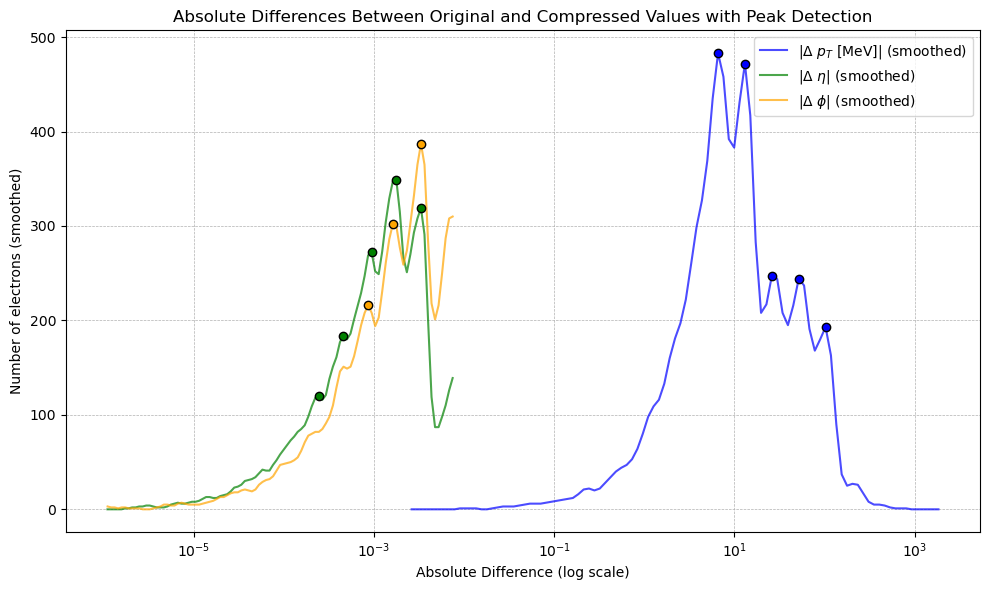


🔍 Log-Scale Peak Spacing Analysis:

 adaptive threshold: 0.000 < 0.05 * 0.298 = 0.015
  • $p_T$ [MeV]: mean Δlog10 = 0.298, std = 0.000 → ✅ Approx. equidistant

 adaptive threshold: 0.017 < 0.05 * 0.283 = 0.014
  • $\eta$: mean Δlog10 = 0.283, std = 0.017 → ❌ Not equidistant

 adaptive threshold: 0.020 < 0.05 * 0.293 = 0.015
  • $\phi$: mean Δlog10 = 0.293, std = 0.020 → ❌ Not equidistant

📊 Global mean Δlog10 spacing = 0.291, std = 0.015


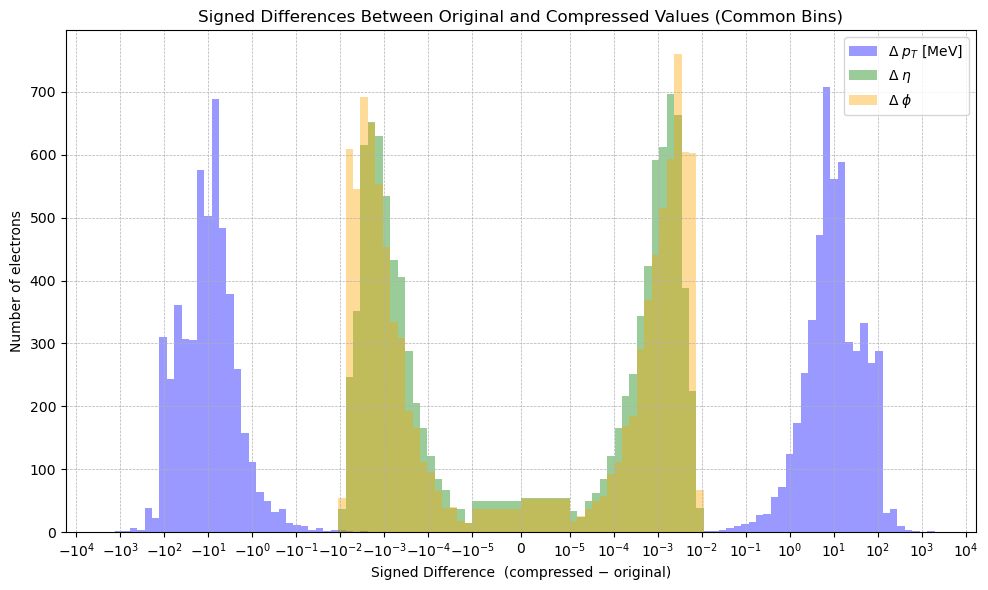

original min: 1299.24755859375, max: 690259.25


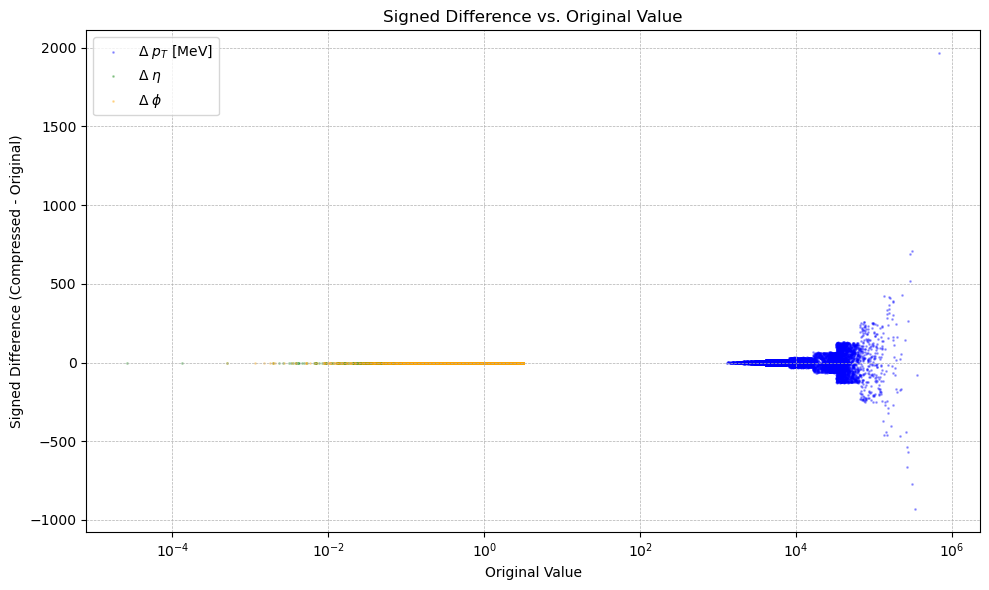

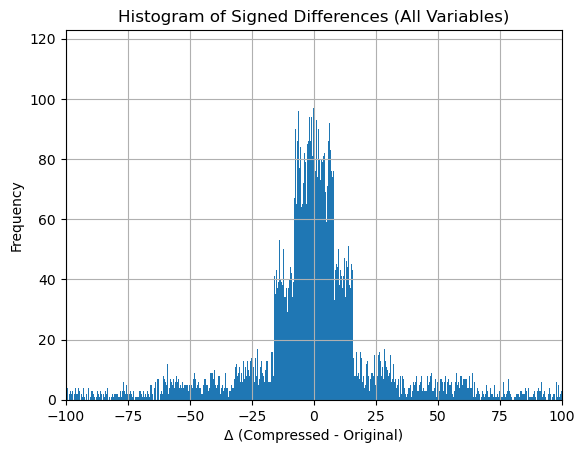

In [5]:
# --- Files ---
index = 0
tree_orig = uproot.open({real_pairs[index][0]: "CollectionTree"})
tree_comp = uproot.open({real_pairs[index][1]: "CollectionTree"})

# --- Variables to Plot ---
variables = {
    "pt": r"$p_T$ [MeV]",
    "eta": r"$\eta$",
    "phi": r"$\phi$"
}
branch_prefix = "AnalysisElectronsAuxDyn"
colors = {"pt": "blue", "eta": "green", "phi": "orange"}

# --- Setup storage ---
original_data = {}
compressed_data = {}
abs_diffs = {}
minval = maxval = 0

# --- Load and compute differences ---
for var, label in variables.items():
    orig_array = ak.flatten(tree_orig[f"{branch_prefix}.{var}"].array()).to_numpy()
    comp_array = ak.flatten(tree_comp[f"{branch_prefix}.{var}"].array()).to_numpy()

    # Filter valid entries and remove near-zero
    mask = np.isfinite(orig_array) & np.isfinite(comp_array) & (np.abs(orig_array) > 1e-13)
    orig = np.abs(orig_array[mask])
    comp = np.abs(comp_array[mask])
    diff_abs = np.abs(orig - comp)
    diff_abs = diff_abs[diff_abs > 1e-6]  # avoid log(0)

    # Store
    original_data[var] = orig
    compressed_data[var] = comp
    abs_diffs[var] = diff_abs


# --- Absolute Differences with Peak Detection ---
plt.figure(figsize=(10, 6))
log_peak_positions = {}  # new dict to store log10 peak positions
equidistant_vars = []

for var, label in variables.items():
    diff = abs_diffs[var]
    diff = diff[np.isfinite(diff) & (diff > 0)]

    if len(diff) == 0:
        continue

    minval = max(np.min(diff), 1e-13)
    maxval = np.max(diff)
    bins = np.logspace(np.log10(minval), np.log10(maxval), 100)

    hist_vals, bin_edges = np.histogram(diff, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Smooth histogram to reduce noise
    smoothed = gaussian_filter1d(hist_vals, sigma=1)

    # Peak detection
    peaks, _ = find_peaks(smoothed, prominence=0.01 * np.max(smoothed), distance=3)
    log_peaks = np.log10(bin_centers[peaks])
    log_peak_positions[label] = log_peaks
    

    # Plot histogram
    plt.plot(bin_centers, smoothed, color=colors[var], label=f"|Δ {label}| (smoothed)", alpha=0.7)

    # Plot detected peaks
    plt.scatter(bin_centers[peaks], smoothed[peaks], color=colors[var], edgecolor='black', zorder=5)

    # Print peak locations
    for i, p in enumerate(peaks):
        peak_val = bin_centers[p]
        peak_height = smoothed[p]
        print(f"🔹 {label} Peak {i+1}: Value = {peak_val:.3e}, Count = {peak_height:.0f}")

plt.xscale("log")
plt.xlabel("Absolute Difference (log scale)")
plt.ylabel("Number of electrons (smoothed)")
plt.title("Absolute Differences Between Original and Compressed Values with Peak Detection")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

def analyze_peak_spacing(log_peaks_dict):
    print("\n🔍 Log-Scale Peak Spacing Analysis:")

    all_diffs = []  # store all Δlog10 spacing values
    equidistant_vars = []

    for var, log_peaks in log_peaks_dict.items():
        if len(log_peaks) < 2:
            print(f"  • {var}: Less than 2 peaks found.")
            continue

        diffs = np.diff(log_peaks)
        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs)
        all_diffs.extend(diffs)

        is_equidistant = std_diff < 0.05 * mean_diff  # adjustable threshold
        print(f"\n adaptive threshold: {std_diff:.3f} < 0.05 * {mean_diff:.3f} = {0.05 * mean_diff:.3f}")
        spacing_str = "✅ Approx. equidistant" if is_equidistant else "❌ Not equidistant"
        if is_equidistant:
            equidistant_vars.append(var)

        print(f"  • {var}: mean Δlog10 = {mean_diff:.3f}, std = {std_diff:.3f} → {spacing_str}")

    # Compute global stats
    if all_diffs:
        global_mean = np.mean(all_diffs)
        global_std = np.std(all_diffs)
        print(f"\n📊 Global mean Δlog10 spacing = {global_mean:.3f}, std = {global_std:.3f}")
    else:
        print("\n⚠️ Not enough peak data to compute global spacing.")
    return global_mean, global_std

delta_mean, delta_std = analyze_peak_spacing(log_peak_positions)

# --------------------------------------------------------------------
#  Signed differences (compressed - original) : symlog visualisation
# --------------------------------------------------------------------
signed_diffs = {}

for var in variables:             # reuse the same loop inputs
    orig = original_data[var]
    comp = compressed_data[var]
    signed = comp - orig
    # keep finite values only
    signed = signed[np.isfinite(signed)]
    signed_diffs[var] = signed
# --- Step 1: Gather all diffs ---
all_signed = np.concatenate([signed_diffs[var] for var in variables])
all_signed = all_signed[np.isfinite(all_signed)]

# --- Step 2: Compute global symmetric-log bin edges ---
thr = 1e-5  # symlog threshold (inside this is linear)
max_abs = max(thr, np.max(np.abs(all_signed)))

bins_pos = np.logspace(np.log10(thr), np.log10(max_abs), 50)
common_bins = np.concatenate((-bins_pos[::-1], [0], bins_pos))

# --- Step 3: Plot with common bins ---
plt.figure(figsize=(10, 6))
for var, label in variables.items():
    diff = signed_diffs[var]
    plt.hist(diff, bins=common_bins, histtype='stepfilled', alpha=0.4,
             color=colors[var], label=f"Δ {label}")

plt.xscale('symlog', linthresh=thr)
plt.xlabel("Signed Difference  (compressed − original)")
plt.ylabel("Number of electrons")
plt.title("Signed Differences Between Original and Compressed Values (Common Bins)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for var, label in variables.items():
    orig = original_data[var]
    diff = compressed_data[var] - orig  # signed diff

    plt.scatter(orig, diff, s=1, alpha=0.3, label=f"Δ {label}", color=colors[var])
print(f'original min: {np.min(np.abs(original_data["pt"]))}, max: {np.max(np.abs(original_data["pt"]))}')
plt.xscale('log')
plt.xlabel("Original Value")
plt.ylabel("Signed Difference (Compressed - Original)")
plt.title("Signed Difference vs. Original Value")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

diff_all = np.concatenate([compressed_data[v] - original_data[v] for v in variables.keys()])
plt.hist(diff_all[np.abs(diff_all)>1e-2], bins=10000)
plt.title("Histogram of Signed Differences (All Variables)")
plt.xlabel("Δ (Compressed - Original)")
plt.ylabel("Frequency")
plt.xlim(-100, 100)
plt.grid(True)
plt.show()



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import uproot
import awkward as ak
from scipy.stats import gaussian_kde

# === Load Data ===
def load_variable(orig_path, comp_path, varname):
    tree_orig = uproot.open({orig_path: "CollectionTree"})
    tree_comp = uproot.open({comp_path: "CollectionTree"})

    x_true = ak.flatten(tree_orig[varname].array()).to_numpy()
    x_recon = ak.flatten(tree_comp[varname].array()).to_numpy()

    # Mask invalid values
    mask = (np.abs(x_true) > 0) & np.isfinite(x_true) & np.isfinite(x_recon)
    return x_true[mask], x_recon[mask]


# === Run the whole thing ===
orig_path = real_pairs[index][0]
comp_path = real_pairs[index][1]
branch = "AnalysisElectronsAuxDyn"
varname = "pt"  # or eta, phi, etc.

x_true, x_recon = load_variable(orig_path, comp_path, branch + "." + varname)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


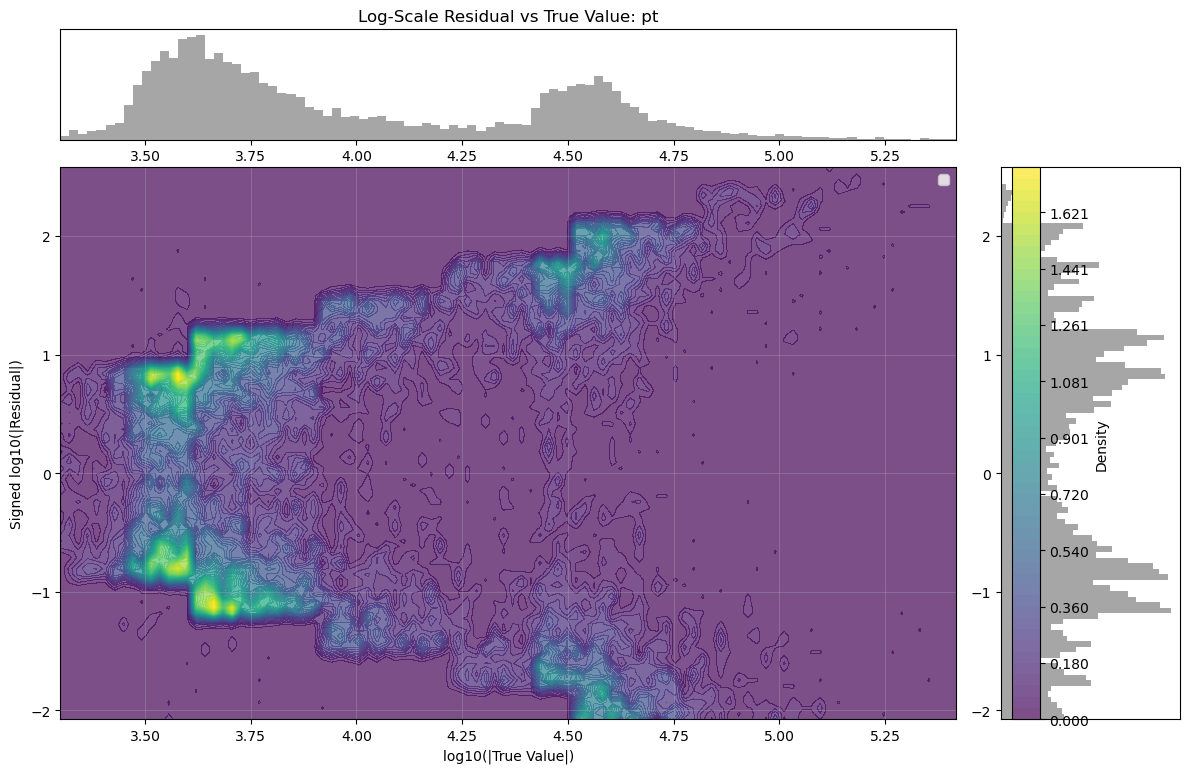

In [7]:
def plot_log_residual_contour(x_true, x_recon, gmm=None, varname="pt"):
    # Calculate residuals and transform to log scale
    residual = x_true - x_recon
    log_x_true = np.log10(np.abs(x_recon) + 1e-12)
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
    
    # Create grid for contours
    x_min, x_max = np.percentile(log_x_true, [1, 99.9])
    y_min, y_max = np.percentile(log_residual, [1, 99.9])
    
    # Create 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        log_x_true, log_residual, 
        bins=100, 
        range=[[x_min, x_max], [y_min, y_max]],
        density=True
    )
    
    # Smooth the histogram
    hist_smooth = gaussian_filter1d(hist, sigma=1)
    
    # Create meshgrid for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    xx, yy = np.meshgrid(x_centers, y_centers)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Contour plot of actual data
    levels = np.linspace(0, hist_smooth.max(), 50)
    cs = plt.contourf(xx, yy, hist_smooth.T, levels=levels, cmap='viridis', alpha=0.7)
    plt.colorbar(cs, label='Density')
    
    # Plot GMM components if provided
    if gmm is not None:
        # Create evaluation grid
        grid = np.column_stack([xx.ravel(), yy.ravel()])
        scores = gmm.score_samples(grid)
        scores = np.exp(scores).reshape(xx.shape)
        
        # Plot GMM contours
        gmm_levels = np.linspace(0, scores.max(), 10)
        plt.contour(xx, yy, scores, levels=gmm_levels, colors='red', linewidths=1, alpha=0.7)
        
        # Plot component means
        plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], 
                   c='red', s=100, marker='x', label='GMM Means')
        plt.scatter(gmm.means_[:, 0], -gmm.means_[:, 1], 
                   c='blue', s=100, marker='o', label='Mirrored Means')
    
    # Formatting
    plt.title(f'Log-Scale Residual vs True Value: {varname}')
    plt.xlabel('log10(|True Value|)')
    plt.ylabel('Signed log10(|Residual|)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add marginal distributions
    ax = plt.gca()
    ax_top = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_right = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    
    # Top marginal (log|x_true| distribution)
    ax_top.hist(log_x_true, bins=x_centers, density=True, color='gray', alpha=0.7)
    ax_top.set_yticks([])
    
    # Right marginal (log|residual| distribution)
    ax_right.hist(log_residual, bins=y_centers, density=True, 
                 orientation='horizontal', color='gray', alpha=0.7)
    ax_right.set_xticks([])
    
    plt.tight_layout()
    plt.show()

# Usage with GMM (optional):
plot_log_residual_contour(x_true, x_recon, None, varname)

# Or without GMM:
# plot_log_residual_contour(x_true, x_recon, None, "pt")

In [8]:
# === Train GMM on (x_recon, log_residual) ===
def train_gmm(x_true, x_recon, n_components=0):
    # Compute residual
    residual = x_true - x_recon
    
    # Apply log transform to both x_recon and residual (with sign preservation)
    sign_residual = np.sign(residual)
    log_abs_x_recon = np.log10(np.abs(x_recon) + 1e-12)
    log_abs_residual = np.log10(np.abs(residual) + 1e-12)
    
    # Training data: (log|x_recon|, sign(residual)*log|residual|)
    X_train = np.vstack([log_abs_x_recon, sign_residual * log_abs_residual]).T

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', 
                         max_iter=1000, n_init=10, random_state=42)
    gmm.fit(X_train)
    return gmm

def predict_correction(gmm, x_recon_input):
    # Ensure input is 1D
    x_recon_input = np.asarray(x_recon_input).flatten()
    
    # Compute log|x_recon| for conditioning
    log_abs_x_recon = np.log10(np.abs(x_recon_input) + 1e-12)
    
    # Initialize output array
    corrected = np.empty_like(x_recon_input)
    
    means = gmm.means_
    covs = gmm.covariances_
    weights = gmm.weights_
    
    for i, (x, x_log) in enumerate(zip(x_recon_input, log_abs_x_recon)):
        # Conditional expectation calculation
        numer = 0
        denom = 0
        
        for k in range(gmm.n_components):
            mean = means[k]
            cov = covs[k]
            
            mu_x, mu_r = mean[0], mean[1]
            var_xx = cov[0, 0]
            cov_xr = cov[0, 1]
            
            # Gaussian PDF for x under component k
            px = np.exp(-0.5 * ((x_log - mu_x)**2 / var_xx))
            
            # Conditional mean of residual given x
            conditional_mean = mu_r + (cov_xr / var_xx) * (x_log - mu_x)
            
            numer += weights[k] * px * conditional_mean
            denom += weights[k] * px
        
        if denom > 0:
            expected_signed_log_residual = numer / denom
            # Transform back to original scale
            sign = np.sign(expected_signed_log_residual)
            abs_residual = 10**(abs(expected_signed_log_residual)) - 1e-12
            expected_residual = sign * abs_residual
        else:
            expected_residual = 0
            
        corrected[i] = x + expected_residual
    
    return corrected  # This is now guaranteed 1D

# Train GMM and correct
gmm = train_gmm(x_true, x_recon, n_components=15)
x_corrected = predict_correction(gmm, x_recon)

 # Calculate MSE
mse_before = np.mean((x_true - x_recon)**2)
mse_after = np.mean((x_true - x_corrected)**2)

# Print results
print(f"\n=== Performance Evaluation ===")
print(f"Variable: {varname}")
print(f"MSE Before Correction: {mse_before:.4e}")
print(f"MSE After Correction: {mse_after:.4e}")
print(f"Improvement: {100*(mse_before - mse_after)/mse_before:.1f}%")


=== Performance Evaluation ===
Variable: pt
MSE Before Correction: 2.8851e+03
MSE After Correction: 2.8536e+03
Improvement: 1.1%


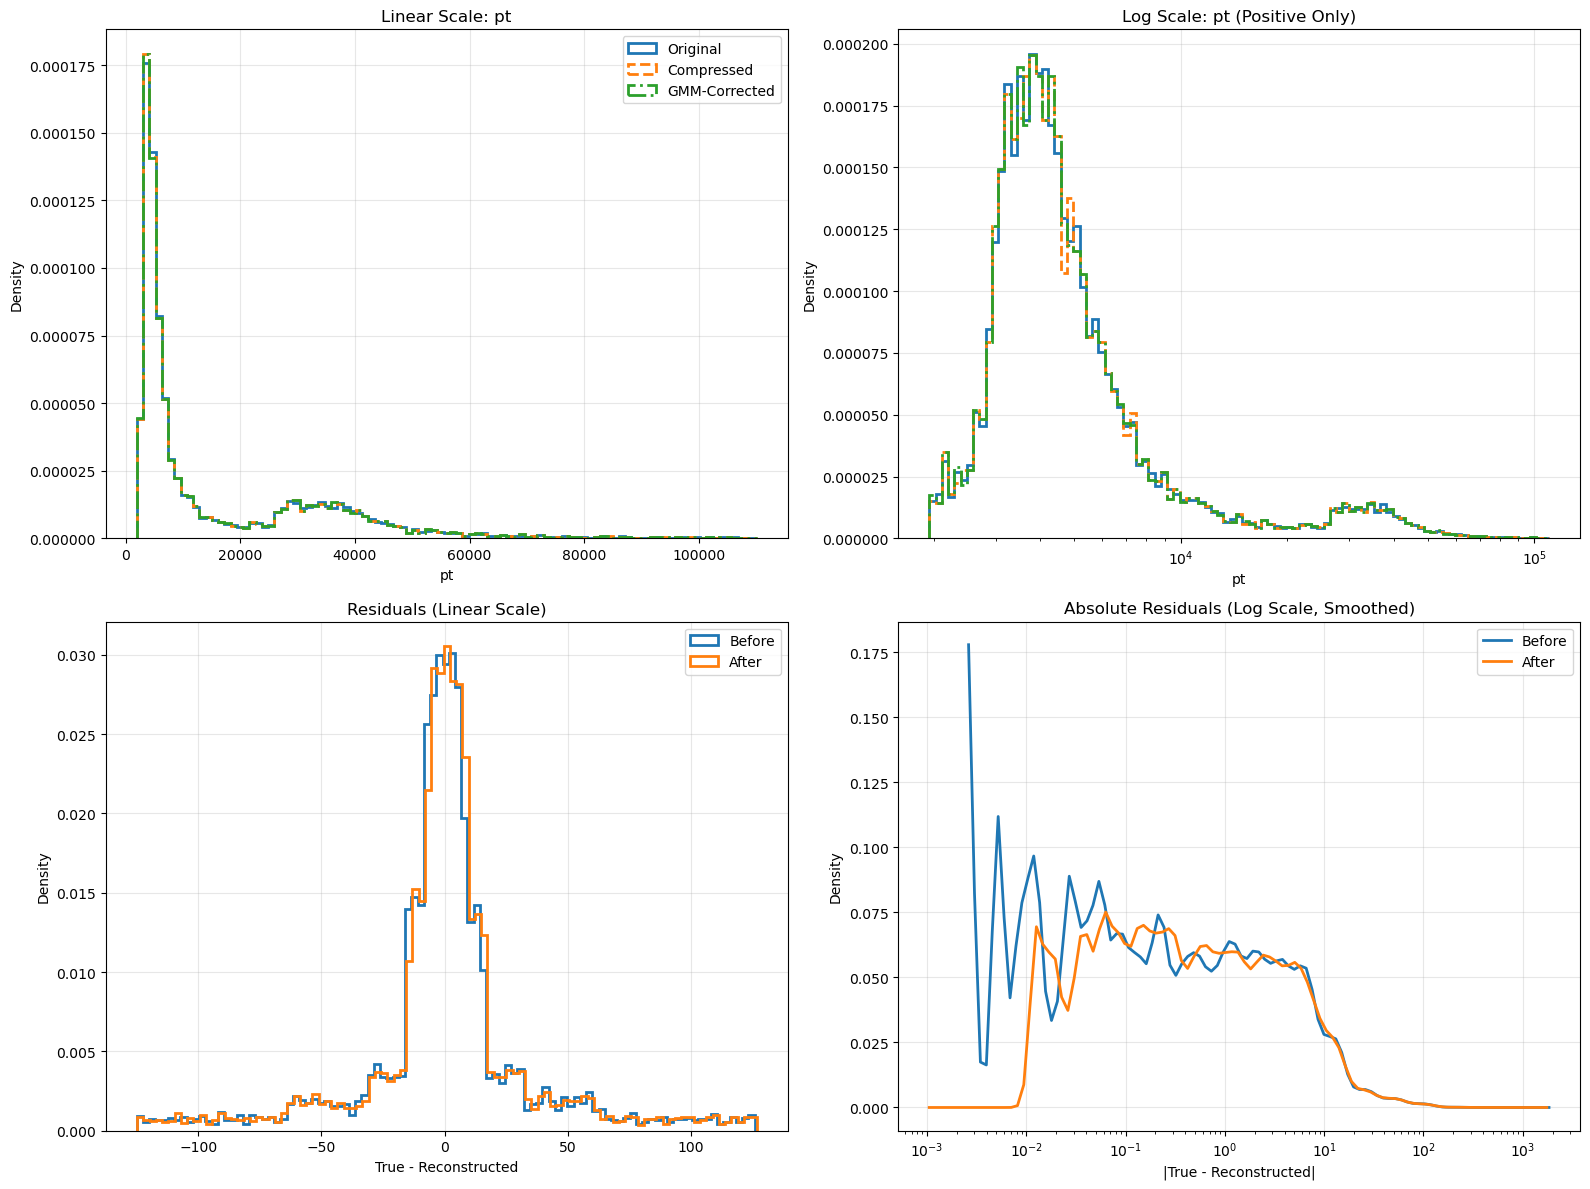

In [9]:
def plot_distributions(x_true, x_recon, x_corrected, varname):
    plt.figure(figsize=(16, 12))
    
    # Panel 1: Linear-scale distributions
    plt.subplot(2, 2, 1)
    bins = np.linspace(np.percentile(x_true, 1), np.percentile(x_true, 99), 100)
    for data, label, style in zip(
        [x_true, x_recon, x_corrected],
        ["Original", "Compressed", "GMM-Corrected"],
        ["-", "--", "-."]
    ):
        plt.hist(data, bins=bins, label=label, histtype='step', 
                linewidth=2, linestyle=style, density=True)
    plt.title(f"Linear Scale: {varname}")
    plt.xlabel(varname)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Panel 2: Log-scale distributions (positive values only)
    plt.subplot(2, 2, 2)
    log_bins = np.logspace(np.log10(max(1e-6, np.percentile(x_true[x_true > 0], 1))),
                         np.log10(np.percentile(x_true, 99)),
                         100)
    for data, label, style in zip(
        [x_true, x_recon, x_corrected],
        ["Original", "Compressed", "GMM-Corrected"],
        ["-", "--", "-."]
    ):
        positive_data = data[data > 0]
        plt.hist(positive_data, bins=log_bins, label=label, histtype='step',
                linewidth=2, linestyle=style, density=True)
    plt.xscale('log')
    plt.title(f"Log Scale: {varname} (Positive Only)")
    plt.xlabel(varname)
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)

    # Panel 3: Linear residuals (histogram)
    plt.subplot(2, 2, 3)
    residuals = [
        ("Before", x_true - x_recon),
        ("After", x_true - x_corrected)
    ]
    for label, res in residuals:
        hist_bins = np.linspace(np.percentile(res, 1), np.percentile(res, 99), 100)
        plt.hist(res, bins=hist_bins, label=label, 
                histtype='step', linewidth=2, density=True)
    plt.title("Residuals (Linear Scale)")
    plt.xlabel("True - Reconstructed")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Panel 4: Log-scale absolute residuals (smoothed histogram)
    plt.subplot(2, 2, 4)
    abs_residuals = [
        ("Before", np.abs(x_true - x_recon)),
        ("After", np.abs(x_true - x_corrected))
    ]
    
    for label, res in abs_residuals:
        positive_res = res[res > 0]
        if len(positive_res) > 0:
            minval = max(np.min(positive_res), 1e-13)
            maxval = np.max(positive_res)
            bins = np.logspace(np.log10(minval), np.log10(maxval), 100)
            
            hist_vals, bin_edges = np.histogram(positive_res, bins=bins, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Apply Gaussian smoothing
            smoothed = gaussian_filter1d(hist_vals, sigma=1)
            
            plt.plot(bin_centers, smoothed, label=label, linewidth=2)
    
    plt.xscale('log')
    plt.title("Absolute Residuals (Log Scale, Smoothed)")
    plt.xlabel("|True - Reconstructed|")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
plot_distributions(x_true, x_recon, x_corrected, varname)

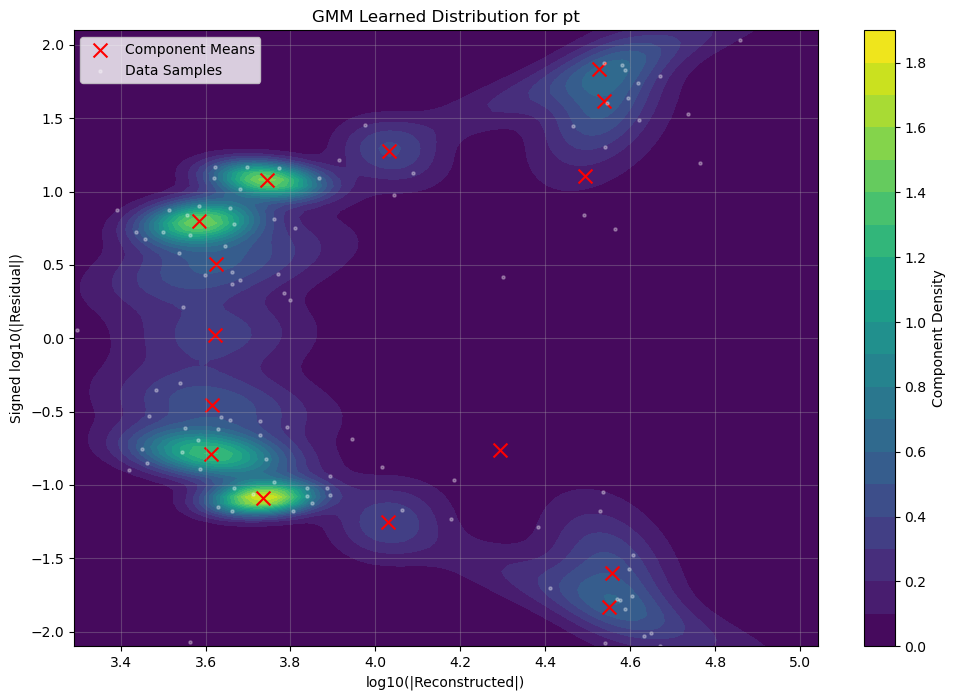


=== GMM Component Information ===
Number of components: 15
Weights: [0.07693713 0.0751468  0.08580536 0.06242105 0.05233819 0.03374855
 0.07360362 0.04664906 0.07287425 0.06088156 0.07296415 0.10593256
 0.06072301 0.0293356  0.09063911]

Component 1:
  Weight: 0.0769
  Mean (log|x_recon|, signed log|residual|): [ 3.61620131 -0.4573296 ]
  Covariance:
[[ 0.02613246 -0.00744098]
 [-0.00744098  0.02940489]]
  Correlation between log|x_recon| and residual: -0.2684

Component 2:
  Weight: 0.0751
  Mean (log|x_recon|, signed log|residual|): [4.53952715 1.61647684]
  Covariance:
[[0.0085123  0.01033829]
 [0.01033829 0.07823028]]
  Correlation between log|x_recon| and residual: 0.4006

Component 3:
  Weight: 0.0858
  Mean (log|x_recon|, signed log|residual|): [3.58565733 0.79583151]
  Covariance:
[[0.00905086 0.00201368]
 [0.00201368 0.01072888]]
  Correlation between log|x_recon| and residual: 0.2043

Component 4:
  Weight: 0.0624
  Mean (log|x_recon|, signed log|residual|): [ 4.55160832 -1.

In [13]:
def visualize_gmm(gmm, x_true, x_recon, varname):
    # Compute the log-transformed data used for training
    residual = x_true - x_recon
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
    log_x_recon = np.log10(np.abs(x_recon) + 1e-12)
    X_train = np.vstack([log_x_recon, log_residual]).T

    # Create a grid for visualization
    x_min, x_max = np.percentile(log_x_recon, [1, 99])
    y_min, y_max = np.percentile(log_residual, [1, 99])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    grid = np.column_stack([xx.ravel(), yy.ravel()])

    # Compute GMM scores on the grid
    scores = gmm.score_samples(grid)
    scores = np.exp(scores)  # Convert log probabilities to probabilities
    scores = scores.reshape(xx.shape)

    # Plot the learned density
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, scores, levels=20, cmap='viridis')
    plt.colorbar(label='Component Density')
    
    # Plot the means of each component
    plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], 
               c='red', s=100, marker='x', label='Component Means')
    
    # Filter points to plot only those within our visualization range
    mask = ((log_x_recon >= x_min) & (log_x_recon <= x_max) & 
            (log_residual >= y_min) & (log_residual <= y_max))

    # Subsample the filtered points for visibility (every 100th point)
    plot_points = mask[::100]
    plt.scatter(log_x_recon[::100][plot_points], 
            log_residual[::100][plot_points],
            c='white', s=5, alpha=0.3, label='Data Samples')
    
    plt.title(f'GMM Learned Distribution for {varname}')
    plt.xlabel('log10(|Reconstructed|)')
    plt.ylabel('Signed log10(|Residual|)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print component information
    print("\n=== GMM Component Information ===")
    print(f"Number of components: {gmm.n_components}")
    print(f"Weights: {gmm.weights_}")
    
    for i, (mean, cov, weight) in enumerate(zip(gmm.means_, gmm.covariances_, gmm.weights_)):
        print(f"\nComponent {i+1}:")
        print(f"  Weight: {weight:.4f}")
        print(f"  Mean (log|x_recon|, signed log|residual|): {mean}")
        print(f"  Covariance:\n{cov}")
        
        # Calculate correlation coefficient
        cov_xr = cov[0,1]
        std_x = np.sqrt(cov[0,0])
        std_r = np.sqrt(cov[1,1])
        correlation = cov_xr / (std_x * std_r)
        print(f"  Correlation between log|x_recon| and residual: {correlation:.4f}")

# Usage after training your GMM:
visualize_gmm(gmm, x_true, x_recon, varname)

In [14]:
from sklearn.base import BaseEstimator, DensityMixin
from sklearn.utils.validation import check_is_fitted
import numpy as np

class SymmetricGMM(BaseEstimator, DensityMixin):
    def __init__(self, n_components=5, max_iter=1000, n_init=10, tol=1e-3, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = tol
        self.random_state = random_state
        
    def fit(self, X, y=None):
        # X should be (log|x_recon|, log|residual|)
        log_x, log_residual_abs = X[:, 0], X[:, 1]
        
        # Create symmetric dataset by duplicating with negative residuals
        X_sym = np.vstack([
            np.column_stack([log_x, log_residual_abs]),
            np.column_stack([log_x, -log_residual_abs])
        ])
        
        # Fit regular GMM on symmetric data
        self.gmm_ = GaussianMixture(
            n_components=self.n_components,
            max_iter=self.max_iter,
            n_init=self.n_init,
            tol=self.tol,
            random_state=self.random_state
        )
        self.gmm_.fit(X_sym)
        
        # Adjust component means to enforce symmetry
        self.means_ = self.gmm_.means_
        self.covariances_ = self.gmm_.covariances_
        self.weights_ = self.gmm_.weights_ / 2  # Because we duplicated data
        
        return self
    
    def score_samples(self, X):
        check_is_fitted(self)
        log_x, log_residual = X[:, 0], X[:, 1]
        
        # Score both positive and negative residuals
        pos_score = self.gmm_.score_samples(np.column_stack([log_x, np.abs(log_residual)]))
        neg_score = self.gmm_.score_samples(np.column_stack([log_x, -np.abs(log_residual)]))
        
        return np.logaddexp(pos_score - np.log(2), neg_score - np.log(2))
    
    def predict(self, X):
        check_is_fitted(self)
        return self.gmm_.predict(np.column_stack([X[:, 0], np.abs(X[:, 1])]))
    
    def predict_proba(self, X):
        check_is_fitted(self)
        return self.gmm_.predict_proba(np.column_stack([X[:, 0], np.abs(X[:, 1])]))


=== Performance Evaluation ===
Variable: pt
MSE Before Correction: 2.8851e+03
MSE After Correction: 2.8859e+03
Improvement: -0.0%


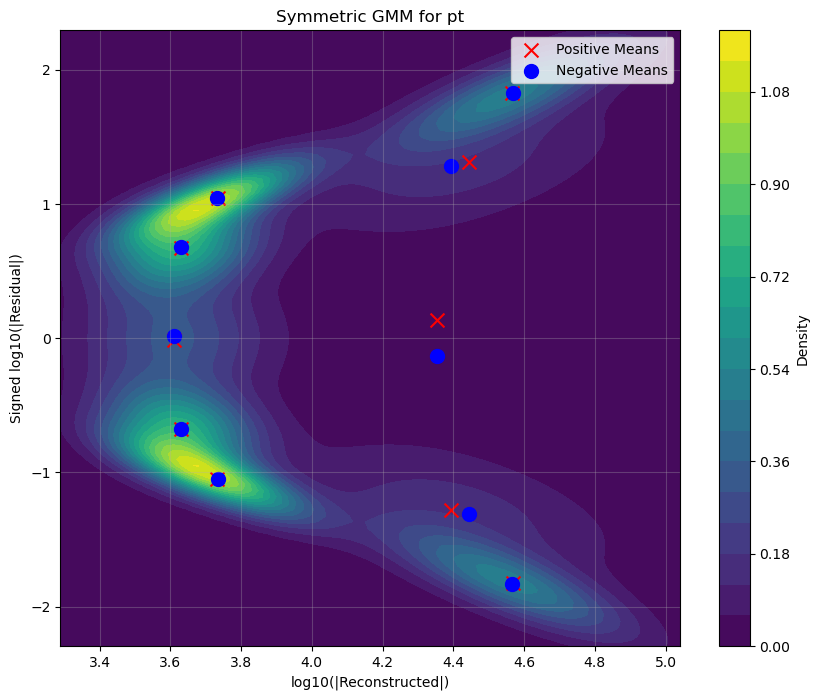


=== Symmetric GMM Components ===

Component 1 (Weight: 0.0657):
  Positive Mean: [ 3.631121   -0.67769539]
  Negative Mean: [3.6311209962839808, 0.6776953883549018]
  Covariance:
[[ 0.01948833 -0.00760314]
 [-0.00760314  0.04746848]]

Component 2 (Weight: 0.0168):
  Positive Mean: [4.3544716  0.13435452]
  Negative Mean: [4.354471604258954, -0.1343545169199636]
  Covariance:
[[ 0.08791749 -0.05628746]
 [-0.05628746  0.66639737]]

Component 3 (Weight: 0.0510):
  Positive Mean: [ 4.56796887 -1.82301721]
  Negative Mean: [4.567968874072751, 1.823017206762518]
  Covariance:
[[ 0.04532558 -0.0447126 ]
 [-0.0447126   0.06979043]]

Component 4 (Weight: 0.0585):
  Positive Mean: [ 3.73066613 -1.04668652]
  Negative Mean: [3.730666134882734, 1.0466865218493733]
  Covariance:
[[ 0.02709793 -0.02420037]
 [-0.02420037  0.03683184]]

Component 5 (Weight: 0.0498):
  Positive Mean: [4.56586098 1.82990033]
  Negative Mean: [4.565860983858572, -1.8299003277808978]
  Covariance:
[[0.04635253 0.04567521

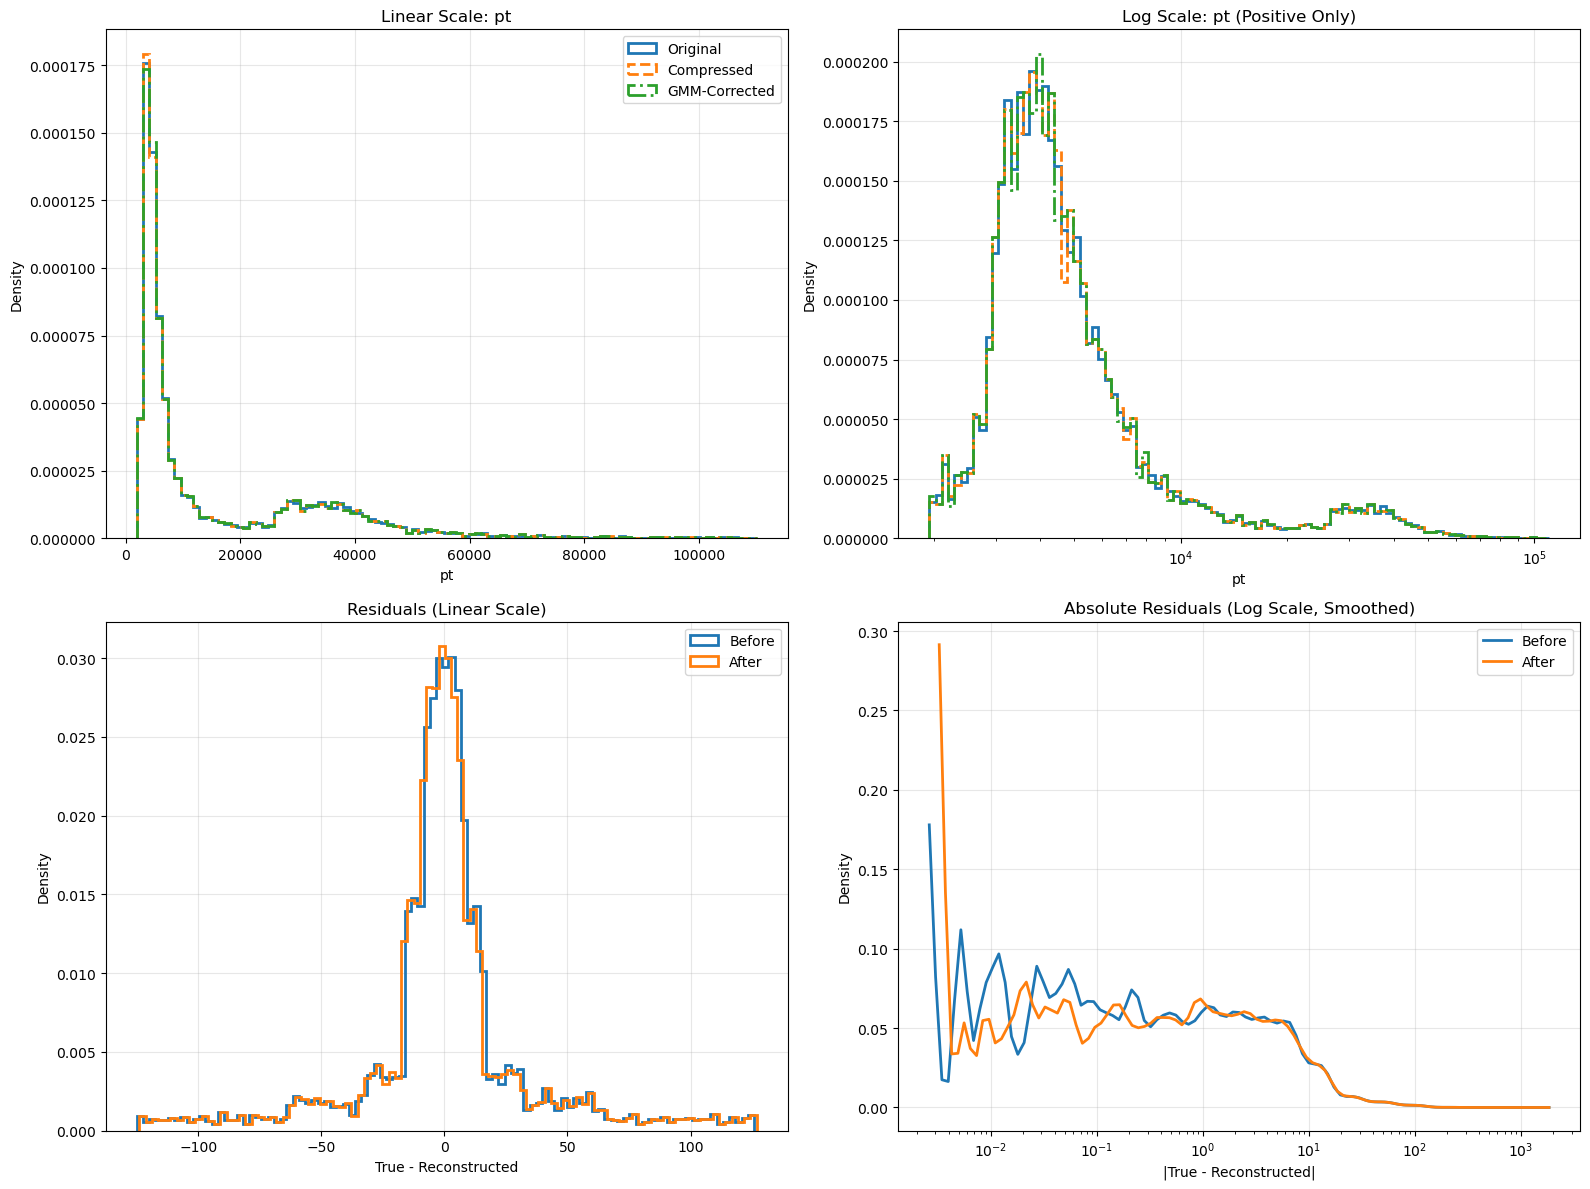

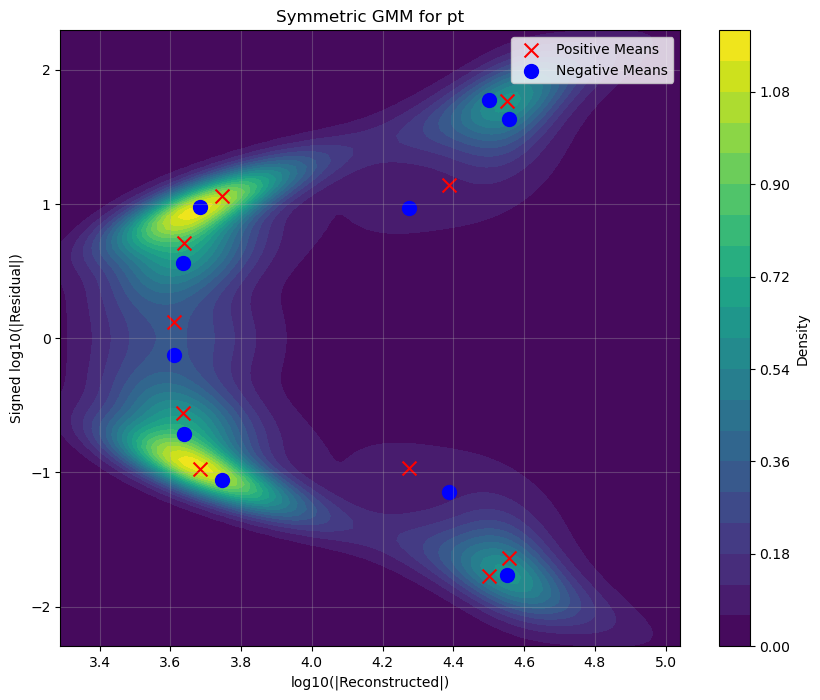


=== Symmetric GMM Components ===

Component 1 (Weight: 0.0361):
  Positive Mean: [ 4.55661302 -1.63501108]
  Negative Mean: [4.556613021918059, 1.6350110835318534]
  Covariance:
[[ 0.00888905 -0.00932394]
 [-0.00932394  0.08186348]]

Component 2 (Weight: 0.0600):
  Positive Mean: [3.74586743 1.05931822]
  Negative Mean: [3.745867429325999, -1.0593182205094989]
  Covariance:
[[0.03664831 0.03344573]
 [0.03344573 0.04544556]]

Component 3 (Weight: 0.0558):
  Positive Mean: [ 3.63674193 -0.55939439]
  Negative Mean: [3.6367419342811087, 0.5593943900503233]
  Covariance:
[[ 0.02084332 -0.01380981]
 [-0.01380981  0.05926904]]

Component 4 (Weight: 0.0532):
  Positive Mean: [4.55198711 1.76641235]
  Negative Mean: [4.551987108855431, -1.76641235022361]
  Covariance:
[[0.02485598 0.02581879]
 [0.02581879 0.06229808]]

Component 5 (Weight: 0.0396):
  Positive Mean: [3.60993972 0.1230711 ]
  Negative Mean: [3.6099397208368993, -0.12307109864034986]
  Covariance:
[[ 0.02595914 -0.00441433]
 [-0

In [17]:
def train_symmetric_gmm(x_true, x_recon, n_components=5):
    residual = x_true - x_recon
    log_residual = np.log10(np.abs(residual) + 1e-12)
    log_x_recon = np.log10(np.abs(x_recon) + 1e-12)
    
    # Train symmetric GMM
    sgmm = SymmetricGMM(n_components=n_components)
    sgmm.fit(np.column_stack([log_x_recon, log_residual]))
    
    return sgmm

def visualize_symmetric_gmm(gmm, x_true, x_recon, varname):
    # Create grid for visualization
    residual = x_true - x_recon
    log_residual = np.log10(np.abs(residual) + 1e-12)
    log_x_recon = np.log10(np.abs(x_recon) + 1e-12)
    
    x_min, x_max = np.percentile(log_x_recon, [1, 99])
    y_min, y_max = np.percentile(log_residual, [1, 99])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(-y_max, y_max, 100))
    grid = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Compute scores
    scores = gmm.score_samples(grid)
    scores = np.exp(scores).reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, scores, levels=20, cmap='viridis')
    plt.colorbar(label='Density')
    
    # Plot component means
    means = gmm.means_
    plt.scatter(means[:, 0], means[:, 1], c='red', s=100, marker='x', label='Positive Means')
    plt.scatter(means[:, 0], -means[:, 1], c='blue', s=100, marker='o', label='Negative Means')
    
    
    plt.title(f'Symmetric GMM for {varname}')
    plt.xlabel('log10(|Reconstructed|)')
    plt.ylabel('Signed log10(|Residual|)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print component info
    print("\n=== Symmetric GMM Components ===")
    for i, (mean, cov, weight) in enumerate(zip(gmm.means_, gmm.covariances_, gmm.weights_)):
        print(f"\nComponent {i+1} (Weight: {weight:.4f}):")
        print(f"  Positive Mean: {mean}")
        print(f"  Negative Mean: [{mean[0]}, {-mean[1]}]")
        print(f"  Covariance:\n{cov}")

def evaluate_symmetric_gmm(x_true, x_recon, varname, n_components=5):
    # Train symmetric GMM
    sgmm = train_symmetric_gmm(x_true, x_recon, n_components)
    
    # Get corrected predictions
    log_x_recon = np.log10(np.abs(x_recon) + 1e-12)
    log_residual = np.log10(np.abs(x_true - x_recon) + 1e-12)
    X = np.column_stack([log_x_recon, log_residual])
    
    # Predict expected residual for each point
    means = sgmm.means_
    covs = sgmm.covariances_
    weights = sgmm.weights_
    
    corrected = []
    for x_log, x in zip(log_x_recon, x_recon):
        # Calculate conditional expectation E[residual | x_recon]
        numer = 0
        denom = 0
        
        for k in range(sgmm.n_components):
            mean = means[k]
            cov = covs[k]
            
            mu_x, mu_r = mean[0], mean[1]
            var_xx = cov[0, 0]
            cov_xr = cov[0, 1]
            
            # Gaussian pdf for x under component k
            px = np.exp(-0.5 * ((x_log - mu_x)**2 / var_xx))
            
            # Conditional mean of residual given x (symmetric version)
            conditional_mean = (cov_xr / var_xx) * (x_log - mu_x)
            
            numer += weights[k] * px * conditional_mean
            denom += weights[k] * px
        
        if denom > 0:
            expected_log_residual = numer / denom
            expected_residual = np.sign(expected_log_residual) * 10**abs(expected_log_residual)
        else:
            expected_residual = 0
            
        corrected.append(x + expected_residual)
    
    x_corrected = np.array(corrected)
    
    # Calculate MSE
    mse_before = np.mean((x_true - x_recon)**2)
    mse_after = np.mean((x_true - x_corrected)**2)
    
    # Print results
    print(f"\n=== Performance Evaluation ===")
    print(f"Variable: {varname}")
    print(f"MSE Before Correction: {mse_before:.4e}")
    print(f"MSE After Correction: {mse_after:.4e}")
    print(f"Improvement: {100*(mse_before - mse_after)/mse_before:.1f}%")
    
    # Visualize what the model learned
    visualize_symmetric_gmm(sgmm, x_true, x_recon, varname)
    
    # Plot distributions before/after
    plot_distributions(x_true, x_recon, x_corrected, varname)
    
    return sgmm, x_corrected

# Usage:
sgmm, x_corrected = evaluate_symmetric_gmm(x_true, x_recon, varname, n_components=10)
# Usage
sgmm = train_symmetric_gmm(x_true, x_recon, n_components=10)
visualize_symmetric_gmm(sgmm, x_true, x_recon, varname)